# Island Ecology

The following data has been downloaded from [Database of Island Invasive Species Eradication](http://diise.islandconservation.org/). To analyze the data, only data quality which was labeled as 'Good' or 'Satisfactory' has been maintained. Also species with less than 20 individuals were discarded.

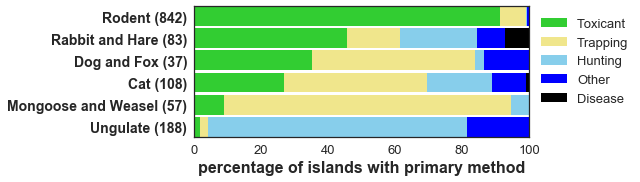

In [16]:
%matplotlib inline
import seaborn as sns
import matplotlib.pylab as pl
import pandas as pd
import numpy as np
from matplotlib import colors
cmap = colors.ListedColormap(['limegreen', 'khaki','skyblue','blue','black'])
#cmap = pl.cm.gist_stern
sns.set(font_scale=1.3)
sns.set_style('white')

min_num_animals = 20
df = pd.read_csv('diise_all_islands.csv',na_values=['null','None'],encoding = "ISO-8859-1")
df = df[df['Data Quality'].isin(['Good','Satisfactory'])]
df = df[~df['Type (Animal)'].isin(['Bird','Mammal (Other)'])]
df.replace({'Primary Eradication Method':{'Unknown':'Other'}},inplace=True)
g = df.groupby('Type (Animal)')
eradication_counts = g['Primary Eradication Method'].value_counts()
eradication_counts = eradication_counts.unstack(fill_value=0) # Assume if not reported it was not done
eradication_counts = eradication_counts[eradication_counts.sum(axis=1)>=min_num_animals]

eradication_ratio = eradication_counts.div(eradication_counts.sum(axis=1),axis=0)*100
eradication_ratio.index=eradication_counts.sum(axis=1).to_frame().apply(lambda x:'%s (%d)'%(x.name,x),axis=1)
col_sorted = eradication_ratio.max().sort_values(ascending=False).index
eradication_ratio = eradication_ratio[col_sorted]
eradication_ratio.sort_values(list(col_sorted),ascending=True,inplace=True,na_position='first')

N = len(eradication_ratio)
fig = eradication_ratio.plot.barh(stacked=True,width=0.9,figsize=(6,N*0.4),cmap=cmap)
fig.legend(bbox_to_anchor=(1., 1),fontsize=13);
fig.set_xlabel('percentage of islands with primary method',fontsize=16,fontweight='bold');
fig.set_yticklabels(fig.get_yticklabels(),fontsize=14,fontweight='bold');
# pl.gca().set_xticklabels(pl.gca().get_xticklabels(),fontsize=10,fontweight='bold');
fig.set_ylabel('')
fig.autoscale(enable=True, axis='both', tight=True)

If a method applied to an animal had less than 10 cases of success and failure it was discarded for the following analysis:

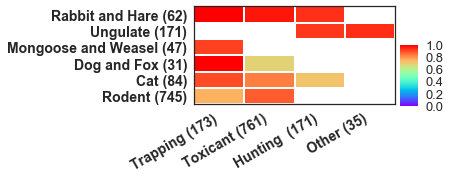

In [4]:
min_num_animals_with_method = 10
df = pd.read_csv('diise_all_islands.csv',na_values=['null','None'],encoding = "ISO-8859-1")
df = df[df['Data Quality'].isin(['Good','Satisfactory'])]
df = df[~df['Type (Animal)'].isin(['Bird','Mammal (Other)'])]
df.replace({'Primary Eradication Method':{'Unknown':'Other'}},inplace=True)
g = df.groupby(['Type (Animal)','Primary Eradication Method'])
eradication_counts = g['Status (Eradication)'].apply(pd.value_counts).reset_index()
eradication_counts = eradication_counts.pivot_table(index=['Type (Animal)','Primary Eradication Method'],
                                                    columns='level_2',values='Status (Eradication)',
                                                    fill_value=0) # Assume if not reported it was not done

eradication_counts = eradication_counts[['Successful','Failed']]
eradication_counts['SuccessPlusFailure'] = eradication_counts['Successful']+eradication_counts['Failed']
eradication_counts['Success Rate'] = eradication_counts['Successful']/eradication_counts['SuccessPlusFailure']
eradication_counts = eradication_counts[eradication_counts['SuccessPlusFailure']>=min_num_animals_with_method]
eradication_counts.sort_values('Success Rate',ascending=False,inplace=True)
eradication_counts.reset_index(inplace=True)
successrate = eradication_counts.pivot(index='Type (Animal)',columns = 'Primary Eradication Method', 
                                       values = 'Success Rate')
del successrate.columns.name
del successrate.index.name

successrate.index=eradication_counts.groupby('Type (Animal)')[['SuccessPlusFailure']].sum().apply(lambda x:'%s (%d)'%(x.name,x),axis=1)
successrate.columns=eradication_counts.groupby('Primary Eradication Method')[['SuccessPlusFailure']].sum().apply(lambda x:'%s (%d)'%(x.name,x),axis=1)

successrate = successrate.loc[successrate.mean(axis=1).sort_values(ascending=False).index]
col_sorted = successrate.notnull().sum().sort_values(ascending=False).index
successrate = successrate[col_sorted]

fig, ax = pl.subplots(1, 1,figsize=(successrate.shape[1]*0.9,successrate.shape[0]*0.3))
cbar_ax = fig.add_axes([0.92, 0.115, .07, 0.47])
# fig = pl.figure(figsize=(successrate.shape[1]*0.9,successrate.shape[0]*0.3))
g = sns.heatmap(successrate,ax=ax,vmax=1,vmin=0,cmap=pl.cm.rainbow,lw=1,cbar_ax=cbar_ax);
# fig = pl.figure(figsize=(successrate.shape[1]*0.9,successrate.shape[0]*0.3))
# g = sns.heatmap(successrate,vmax=1,vmin=0,cmap=pl.cm.rainbow,lw=1);
for _, spine in g.spines.items():
    spine.set_visible(True)
    
g.set_yticklabels(g.get_yticklabels(),fontsize=14,fontweight='bold',rotation=0);    
g.set_xticklabels(g.get_xticklabels(),fontsize=14,fontweight='bold',rotation=30,ha='right');    
# fig.axes[1].collections[0].set_edgecolor("face")
# cbar_ax = fig.axes[1].collections[0].axes
# cbar_ax.set_aspect(4)

# Cancer Treatment

The following data has been downloaded from [TumorPortal](http://dev.tumorportal.org/charts/genomics). Almost half of patients were removed from analysis because their time of death was zero (quite odd!). A therapy was considered succussful if the patient lasted more than 2 years.

In [5]:
usecols = [u'Bcr Patient Barcode', u'Death Days to Calc',u'Drug_start_days_aligned', 
           u'Pharmaceutical Therapy Type calc',u'Vital Status', u'tumor_type']
df = pd.read_csv('Treatment_chart_crosstab.txt',sep='\t',usecols=usecols,
                 dtype=dict(zip(usecols,[str,float,float,str,str,str])))

In [6]:
g = df.groupby('Bcr Patient Barcode')
g_filt = df[df['Pharmaceutical Therapy Type calc']!='No drug prescribed'].groupby('Bcr Patient Barcode')
survival_data = pd.concat([g['tumor_type'].first(),
                           g['Death Days to Calc'].max(),  # death must happen at the latest day
                           g['Vital Status'].apply(lambda x:(x=='Dead').any()), # if one field is Dead patient must have died
                           g_filt['Drug_start_days_aligned'].min(), # earliest time recorded which is not labeled as 'No drug prescribed'
                           g_filt.apply(lambda x:'/'.join(set(x['Pharmaceutical Therapy Type calc'][
                               x['Drug_start_days_aligned'] == x['Drug_start_days_aligned'].min()
                           ].dropna())))  # joins all drug names that were prescribed first
                          ],axis=1)
survival_data.rename(columns={0:'first therapy'},inplace=True)
survival_data['TherapyToLastDay'] = survival_data['Death Days to Calc'] - survival_data['Drug_start_days_aligned']
survival_data.replace({'first therapy':{'':np.nan},  # If no first therapy, remove the field
                       'Death Days to Calc':{0:np.nan}},inplace=True)  # Remove cases with death time set to 0 (these are odd. Why are they there? half of data is like that)
survival_data.dropna(axis=0,inplace=True)

In [7]:
from lifelines import KaplanMeierFitter
def get_servrate(survival_data,days_to_succeed = 5*365.):
    kmf = KaplanMeierFitter()
    kmffit = kmf.fit(survival_data["TherapyToLastDay"], event_observed=survival_data["Vital Status"])
    t = kmffit.timeline[np.argmax(kmffit.timeline>=days_to_succeed)-1]
    CI_upper = kmffit.confidence_interval_.loc[t,'KM_estimate_upper_0.95']
    CI_lower = kmffit.confidence_interval_.loc[t,'KM_estimate_lower_0.95']
    n1 = np.float(survival_data.loc[survival_data["TherapyToLastDay"]<=t,"Vital Status"].count())
    e1 = np.float(survival_data.loc[survival_data["TherapyToLastDay"]<=t,"Vital Status"].sum())
    n2 = np.float(survival_data.loc[survival_data["TherapyToLastDay"]>t,"Vital Status"].count())
    e2 = np.float(survival_data.loc[survival_data["TherapyToLastDay"]>t,"Vital Status"].sum())
    return pd.Series({'survival_rate':kmffit.survival_function_.loc[t,'KM_estimate'],
                      'survival_rate_error':CI_upper-CI_lower,
                      'CI_upper':CI_upper,'CI_lower':CI_lower,
                      'total_counts':n1+n2,'time_used':t,
                      'ratio_died_after':e2/n2 if n2>0 else np.nan,'ratio_died_before':e1/n1 if n1>0 else np.nan,
                      'n1':n1,'e1':e1,'n2':n2,'e2':e2,
                      'old_total_counts':e1+n2,
                      'old_successrate':e2/(e1+n2) if (e1+n2)>0 else np.nan}) # percentage of cases that survived after t given they were not censored before

survival_data_crunched_2 = survival_data.groupby(['tumor_type','first therapy']).apply(lambda x: get_servrate(x,days_to_succeed = 2*365.))
survival_data_crunched_5 = survival_data.groupby(['tumor_type','first therapy']).apply(lambda x: get_servrate(x,days_to_succeed = 5*365.))

In [8]:
survival_data_crunched_2.head(7)

CI_lower  CI_upper    e1   e2    n1  \
tumor_type first therapy                                                     
ACC        Chemotherapy                     NaN       NaN   0.0  0.0   0.0   
           Chemotherapy/Radiotherapy   0.000000  0.000000   1.0  0.0   1.0   
           Radiotherapy                0.342155  0.862374   4.0  1.0   5.0   
           Targeted molecular therapy       NaN       NaN   0.0  0.0   1.0   
BLCA       Ancillary/Chemotherapy           NaN       NaN   0.0  0.0   0.0   
           Chemotherapy                0.520407  0.728791  31.0  5.0  60.0   
           Chemotherapy/Radiotherapy   0.000000  0.000000   2.0  0.0   2.0   

                                         n2  old_successrate  \
tumor_type first therapy                                       
ACC        Chemotherapy                 1.0         0.000000   
           Chemotherapy/Radiotherapy    0.0         0.000000   
           Radiotherapy                 8.0         0.083333   
           Targeted molecular therapy   0.0              NaN   
BLCA       Ancillary/Chemotherapy       1.0         0.000000   
           Chemotherapy                37.0         0.073529   
           Chemotherapy/Radiotherapy    0.0         0.000000   

                                       old_total_counts  ratio_died_after  \
tumor_type first therapy                                                    
ACC        Chemotherapy                             1.0          0.000000   
           Chemotherapy/Radiotherapy                1.0               NaN   
           Radiotherapy                            12.0          0.125000   
           Targeted molecular therapy               0.0               NaN   
BLCA       Ancillary/Chemotherapy                   1.0          0.000000   
           Chemotherapy                            68.0          0.135135   
           Chemotherapy/Radiotherapy                2.0               NaN   

                                       ratio_died_before  survival_rate  \
tumor_type first therapy                                                  
ACC        Chemotherapy                              NaN       1.000000   
           Chemotherapy/Radiotherapy            1.000000       0.000000   
           Radiotherapy                         0.800000       0.671329   
           Targeted molecular therapy           0.000000       1.000000   
BLCA       Ancillary/Chemotherapy                    NaN       1.000000   
           Chemotherapy                         0.516667       0.634721   
           Chemotherapy/Radiotherapy            1.000000       0.000000   

                                       survival_rate_error  time_used  \
tumor_type first therapy                                                
ACC        Chemotherapy                                NaN        0.0   
           Chemotherapy/Radiotherapy              0.000000      474.0   
           Radiotherapy                           0.520219      472.0   
           Targeted molecular therapy                  NaN      325.0   
BLCA       Ancillary/Chemotherapy                      NaN        0.0   
           Chemotherapy                           0.208384      721.0   
           Chemotherapy/Radiotherapy              0.000000      258.0   

                                       total_counts  
tumor_type first therapy                             
ACC        Chemotherapy                         1.0  
           Chemotherapy/Radiotherapy            1.0  
           Radiotherapy                        13.0  
           Targeted molecular therapy           1.0  
BLCA       Ancillary/Chemotherapy               1.0  
           Chemotherapy                        97.0  
           Chemotherapy/Radiotherapy            2.0

In the following analysis if there were less than 50 individuals with treatment in for a cancer study it was discarded:

In [9]:
TCGAStudyAbbreviations = pd.read_csv('TCGA Study Abbreviations.txt',sep=' \t',index_col=0,engine='python')
TCGAStudyAbbreviations

,StudyName
StudyAbbreviation,
LAML,Acute Myeloid Leukemia
ACC,Adrenocortical carcinoma
BLCA,Bladder Urothelial Carcinoma
LGG,Brain Lower Grade Glioma
BRCA,Breast invasive carcinoma
CESC,Cervical squamous cell carcinoma and endocervi...
CHOL,Cholangiocarcinoma
LCML,Chronic Myelogenous Leukemia
COAD,Colon adenocarcinoma


In [10]:
min_disease_size = 50
survival_data_counts = survival_data_crunched_5['total_counts'].unstack(fill_value = 0)
survival_data_counts.index = TCGAStudyAbbreviations.loc[survival_data_counts.index,'StudyName']
del survival_data_counts.index.name
survival_data_counts = survival_data_counts[survival_data_counts.sum(axis=1)>=min_disease_size]
survival_data_counts.index = survival_data_counts.sum(axis=1).to_frame().apply(lambda x:'%s (%d)'%(x.name,x),axis=1)

In the following analysis all methods which at most 5 percent of patients received are combined together as 'Other':

In [11]:
min_survival_data_ratio = 5
survival_data_ratio = survival_data_counts.div(survival_data_counts.sum(axis=1),axis=0)*100
col_sorted = survival_data_ratio.max().sort_values(ascending=False).index
survival_data_ratio = survival_data_ratio[col_sorted]
survival_data_ratio.sort_values(list(col_sorted),ascending=True,inplace=True,na_position='first')
keep_cols = survival_data_ratio.max()>=min_survival_data_ratio
temp = survival_data_ratio.loc[:,~keep_cols].sum(axis=1)
survival_data_ratio = survival_data_ratio.loc[:,keep_cols]
survival_data_ratio['Other'] = temp

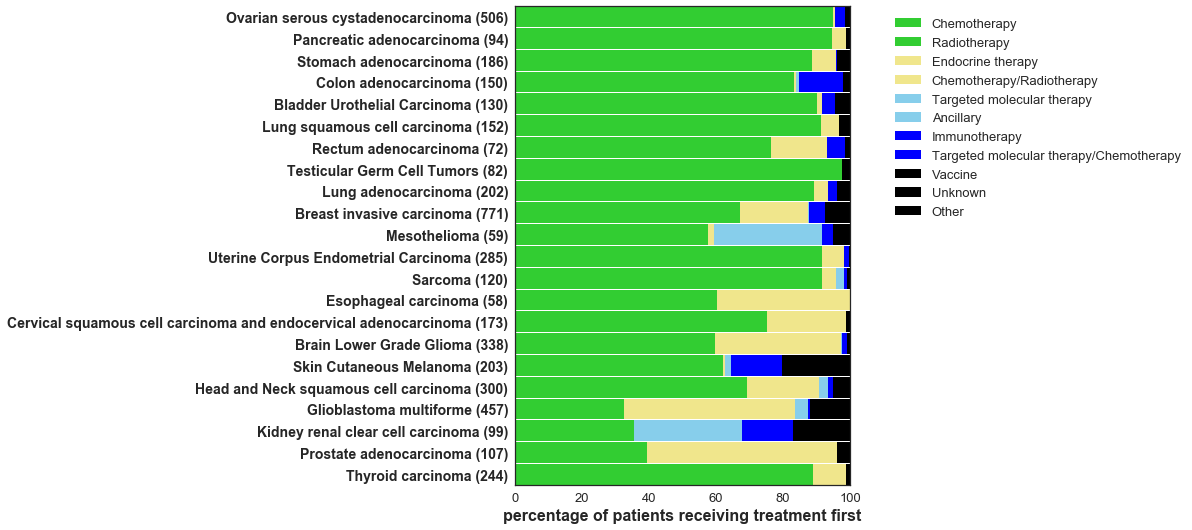

In [17]:
cmap = colors.ListedColormap(['limegreen', 'khaki','skyblue','blue','black'])
#cmap=pl.cm.gist_stern
N = len(survival_data_ratio)
sns.set_style('white')
g = survival_data_ratio.plot.barh(
    stacked=True,width=0.95,figsize=(6,N*0.4),cmap=cmap)
g.legend(bbox_to_anchor=(1.1, 1),ncol=1,fontsize=13);
g.set_xlabel('percentage of patients receiving treatment first',fontsize=16,fontweight='bold');
pl.gca().autoscale(enable=True, axis='both', tight=True)
g.set_yticklabels(g.get_yticklabels(),fontsize=14,fontweight='bold');

For the following analysis if there were less than 20 patients in a therapy it was discarded:

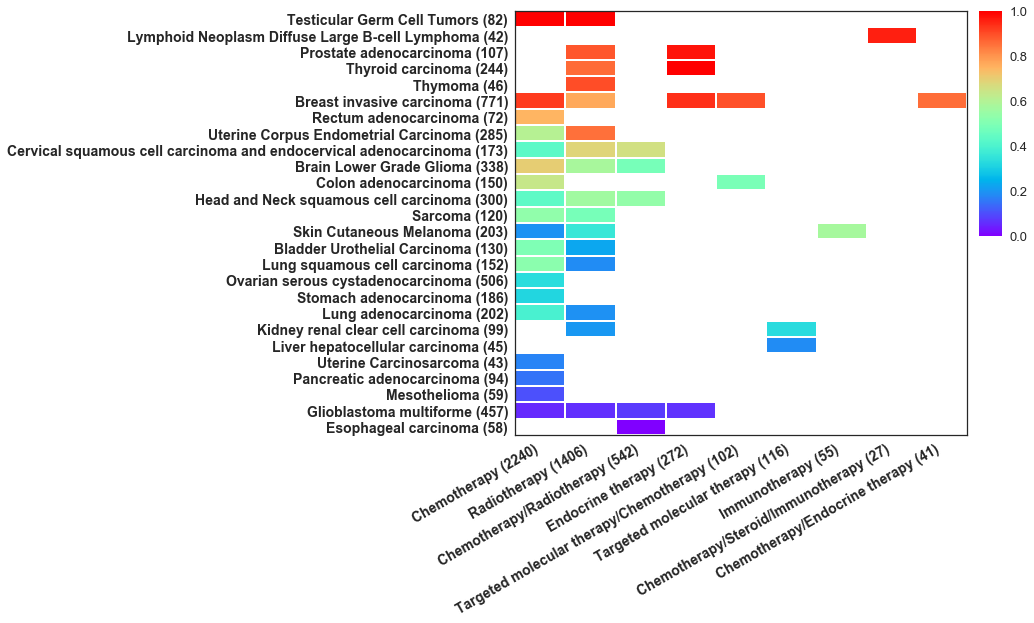

In [13]:
min_diseasetherapy_size = 20

# successstats = survival_data.groupby(['tumor_type','first therapy']).apply(
#     lambda x:pd.Series({'successrate':np.mean(x['success']),'count':len(x['success'])}))

successrate = survival_data_crunched_5.loc[survival_data_crunched_5['total_counts']>=min_diseasetherapy_size,'survival_rate'] # make sure there are at least 10 samples in the group
successrate = successrate.unstack()
del successrate.index.name
del successrate.columns.name
successrate = successrate.loc[successrate.mean(axis=1).sort_values(ascending=False).index]
col_sorted = successrate.notnull().sum().sort_values(ascending=False).index
successrate = successrate[col_sorted]

tumorcounts = survival_data_crunched_5.reset_index().groupby('tumor_type')[['total_counts']].sum()
successrate.index = tumorcounts.apply(lambda x:'%s (%d)'%(TCGAStudyAbbreviations.loc[x.name,'StudyName'],x),axis=1)[successrate.index]
successrate.columns = survival_data_crunched_5.reset_index().groupby('first therapy')[['total_counts']].sum().apply(lambda x:'%s (%d)'%(x.name,x),axis=1)[successrate.columns]

fig, ax = pl.subplots(1, 1,figsize=(successrate.shape[1]*0.9,successrate.shape[0]*0.3))
cbar_ax = fig.add_axes([0.92, 0.48, .04, .4])
# fig = pl.figure(figsize=(successrate.shape[1]*0.9,successrate.shape[0]*0.3))
g = sns.heatmap(successrate,ax=ax,vmax=1,vmin=0,cmap=pl.cm.rainbow,lw=1,cbar_ax=cbar_ax);
for _, spine in g.spines.items():
    spine.set_visible(True)
    
g.set_yticklabels(g.get_yticklabels(),fontsize=14,fontweight='bold',rotation=0);    
g.set_xticklabels(g.get_xticklabels(),fontsize=14,fontweight='bold',rotation=30,ha='right');        
# cbar_ax = fig.axes[1].collections[0].axes
# cbar_ax.set_aspect(5)
# temp = fig.axes[1]
# temp.set_aspect(4)

Plot of errors on survival rates. Cases where error was NaN are set to -1:

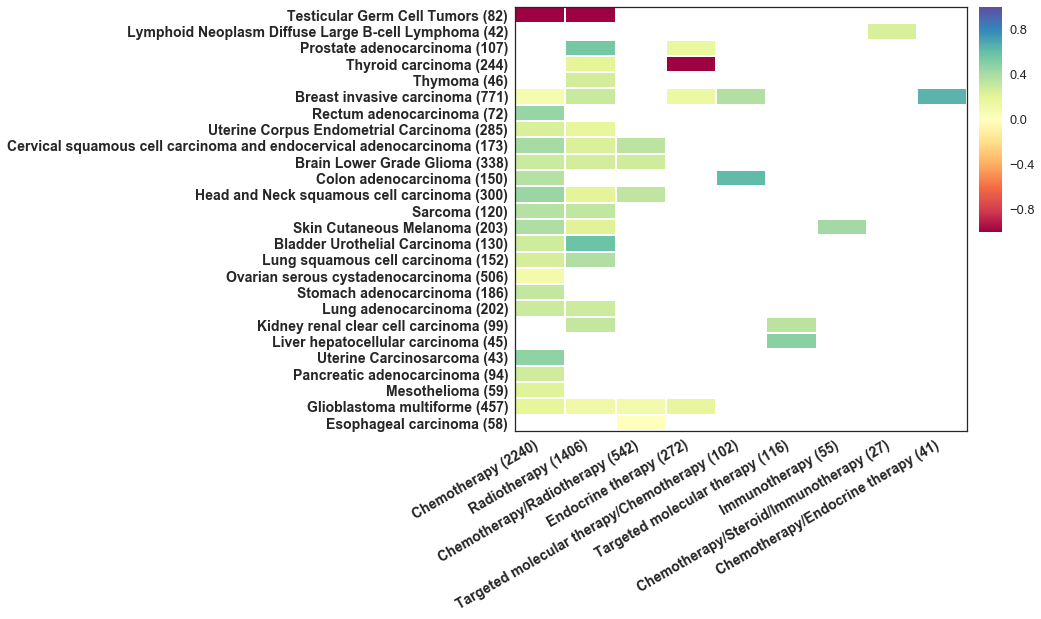

In [14]:
errors = survival_data_crunched_5.loc[survival_data_crunched_5['total_counts']>=min_diseasetherapy_size,'survival_rate_error'].fillna(-1).unstack()
errors.index = tumorcounts.apply(lambda x:'%s (%d)'%(TCGAStudyAbbreviations.loc[x.name,'StudyName'],x),axis=1)[errors.index]
errors.columns = survival_data_crunched_5.reset_index().groupby('first therapy')[['total_counts']].sum().apply(lambda x:'%s (%d)'%(x.name,x),axis=1)[errors.columns]

errors = errors.loc[successrate.index,successrate.columns]

fig, ax = pl.subplots(1, 1,figsize=(errors.shape[1]*0.9,errors.shape[0]*0.3))
cbar_ax = fig.add_axes([0.92, 0.48, .04, .4])
g = sns.heatmap(errors,ax=ax,vmax=1.,vmin=-1.,cmap=pl.cm.Spectral,lw=1,cbar_ax=cbar_ax);
for _, spine in g.spines.items():
    spine.set_visible(True)
    
g.set_yticklabels(g.get_yticklabels(),fontsize=14,fontweight='bold',rotation=0);    
g.set_xticklabels(g.get_xticklabels(),fontsize=14,fontweight='bold',rotation=30,ha='right'); 

# Scratch

In [666]:
# min_disease_size = 20
# survival_data_counts = survival_data_crunched[['old_successrate','old_total_counts']].dropna()
# # survival_data_counts = survival_data_crunched.loc[survival_data_crunched['old_successrate'].dropna().index,'old_total_counts'].unstack(fill_value = 0)
# survival_data_counts = survival_data_counts['old_total_counts'].unstack(fill_value = 0)
# # del survival_data_counts.columns.name
# del survival_data_counts.index.name
# survival_data_counts = survival_data_counts[survival_data_counts.sum(axis=1)>=min_disease_size]

survival_data['success'] = survival_data['TherapyToLastDay']>days_to_succeed
survival_data = survival_data[survival_data['Vital Status'] | survival_data['success']]  # Only keep patients that either died or, if alive, lasted longer than specified time

min_disease_size = 20
g = survival_data.groupby(['tumor_type','first therapy'])
survival_data_counts = g['success'].count()
survival_data_counts = survival_data_counts.unstack(fill_value = 0)
del survival_data_counts.columns.name
del survival_data_counts.index.name
survival_data_counts = survival_data_counts[survival_data_counts.sum(axis=1)>=min_diseasetherapy_size]

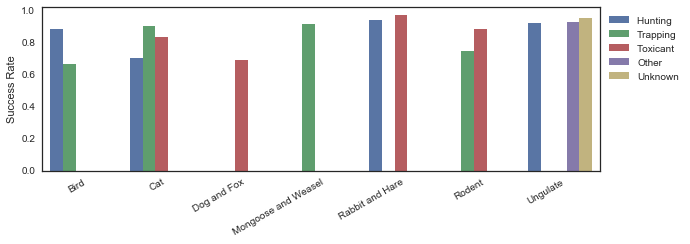

In [244]:
import seaborn as sns
sns.set_style('white')
df = pd.read_csv('diise_almost_all_islands.csv',na_values=['null','None'])
df = df[df['Data Quality'].isin(['Good','Satisfactory'])]
AcceptableSpecies = df['Type (Animal)'].value_counts()>20
# df = df.groupby('Type (Animal)')['Primary Eradication Method'].value_counts().unstack()
# df = df.loc[AcceptableSpecies]
df = df.groupby(['Type (Animal)','Primary Eradication Method'])['Status (Eradication)'].apply(pd.value_counts).reset_index().pivot_table(index=['Type (Animal)','Primary Eradication Method'],columns='level_2',values='Status (Eradication)')
df['SuccessPlusFailure'] = df['Successful']+df['Failed']
df['Success Rate'] = df['Successful']/df['SuccessPlusFailure']#df.sum(axis=1,skipna=True)
df = df[df['SuccessPlusFailure']>=10]
del df.columns.name
# del df.index.name

pl.figure(figsize=(10,3))
g = sns.barplot(x='Type (Animal)',y='Success Rate',hue='Primary Eradication Method',data=df.reset_index())
g.legend(bbox_to_anchor=(1,1))
g.set_xticklabels(g.get_xticklabels(),rotation=30,ha="right",rotation_mode='anchor');
g.set_ylabel('Success Rate');
g.set_xlabel('');

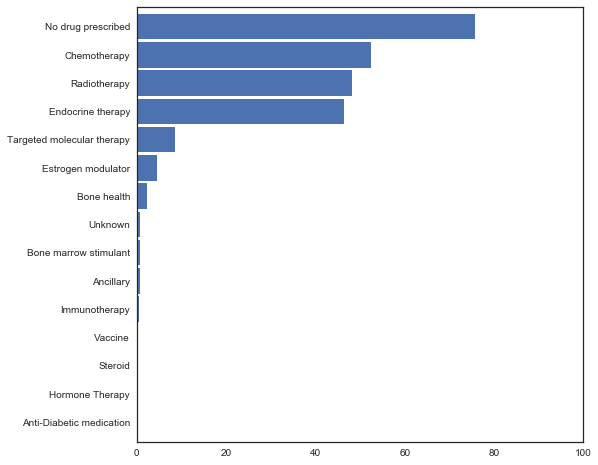

In [300]:
import matplotlib.pylab as pl
(temp.notnull().T.mean(axis=1).sort_values(ascending=True)*100).plot.barh(figsize=(8,8),width=.9)
pl.xlim([0,100]);

The following is the distribution plot when the survival information is ignored (almost half of samples are lost when survival information is incorporated because of sparsity of clinical data.):

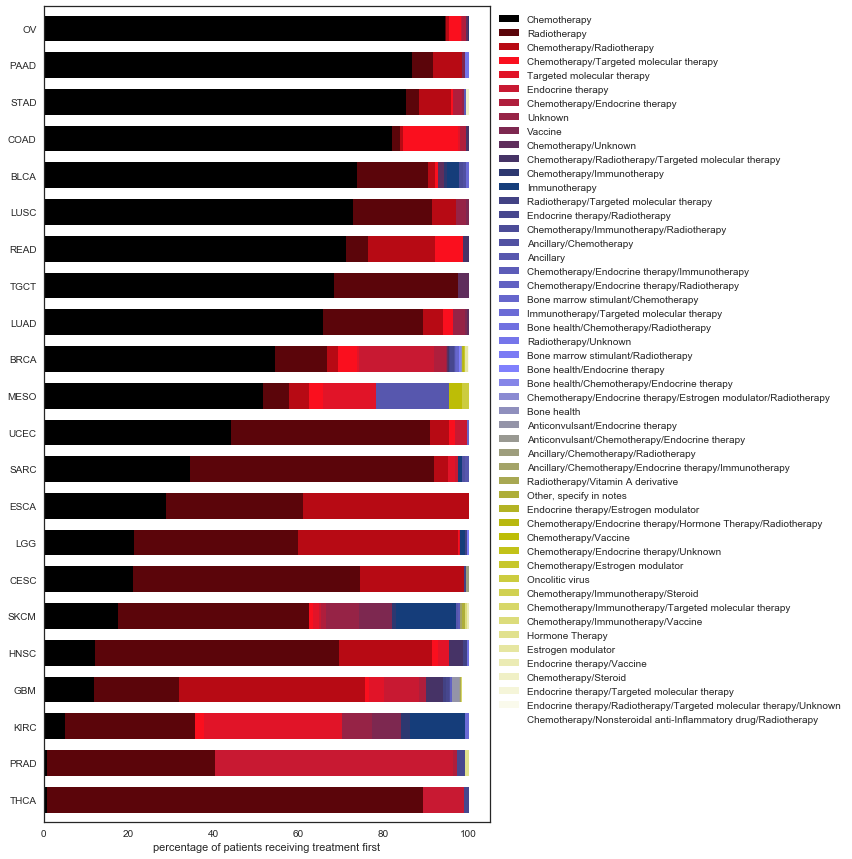

In [489]:
df = pd.read_csv('Treatment_chart_crosstab.txt',sep='\t')
# df = df.groupby(['Tumor type','Bcr Patient Barcode'])['Pharmaceutical Therapy Type calc'].apply(pd.value_counts)
df = df[['Tumor type','Bcr Patient Barcode','Pharmaceutical Therapy Type calc','Drug_start_days_aligned']].drop_duplicates()
df = df[df['Pharmaceutical Therapy Type calc']!='No drug prescribed'].dropna()

df = df.groupby(['Tumor type','Bcr Patient Barcode','Pharmaceutical Therapy Type calc'])['Drug_start_days_aligned'].min()
df = df.reset_index()

df = df.pivot_table(index=['Tumor type','Bcr Patient Barcode'],
               columns=['Pharmaceutical Therapy Type calc'],
               values='Drug_start_days_aligned')

df = df.subtract(df.min(axis=1),axis=0)==0
df = df.apply(lambda x: '/'.join(df.columns[x]),axis=1)
df = df.reset_index().groupby('Tumor type')[0].apply(pd.value_counts).reset_index()
df = df.pivot(values=0,index='Tumor type',columns='level_1')
del df.index.name
del df.columns.name
df = df[df.sum(axis=1)>=50]
df.dropna(how='all',axis=1,inplace=True)
df

dfratio = df.div(df.sum(axis=1),axis=0)*100
col_sorted = dfratio.notnull().sum().sort_values(ascending=False).index
dfratio = dfratio[col_sorted]
dfratio.sort_values(list(col_sorted),ascending=True,inplace=True,na_position='first')

g = dfratio.loc[:,dfratio.max()>=0].plot.barh(stacked=True,width=0.7,figsize=(8,15),cmap=pl.cm.gist_stern)
g.legend(bbox_to_anchor=(1., 1));
g.set_xlabel('percentage of patients receiving treatment first');

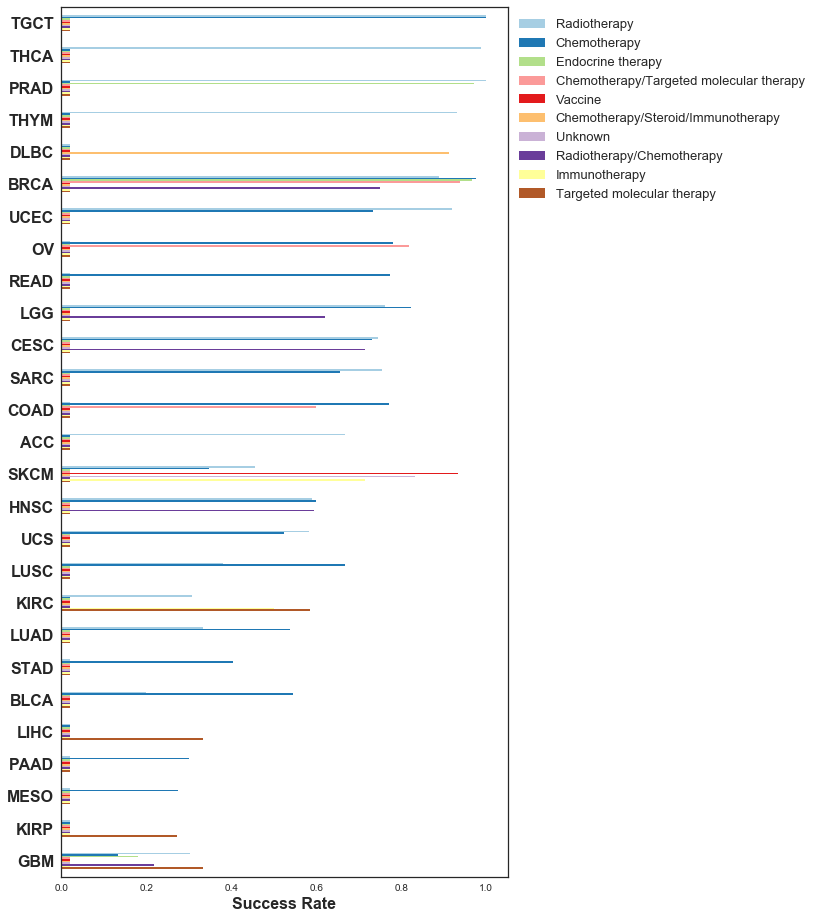

In [522]:
df = successrate['successrate'].unstack()
del df.index.name
df = df.loc[:,df.max()>=.5]
df = df.loc[df.mean(axis=1).sort_values(ascending=False).index]
col_sorted = df.max().sort_values(ascending=False).index
df = df[col_sorted]#.sort_values(list(col_sorted),ascending=True,na_position='first')
df.fillna(0.02).plot.barh(stacked=False,
                          width=.5,figsize=(8,16),cmap=pl.cm.Paired).legend(bbox_to_anchor=(1,1),fontsize=13)
pl.xlabel('Success Rate',fontsize=16,fontweight='bold');
g = pl.gca()
g.set_yticklabels(g.get_yticklabels(),fontsize=16,fontweight='bold');
g.invert_yaxis()

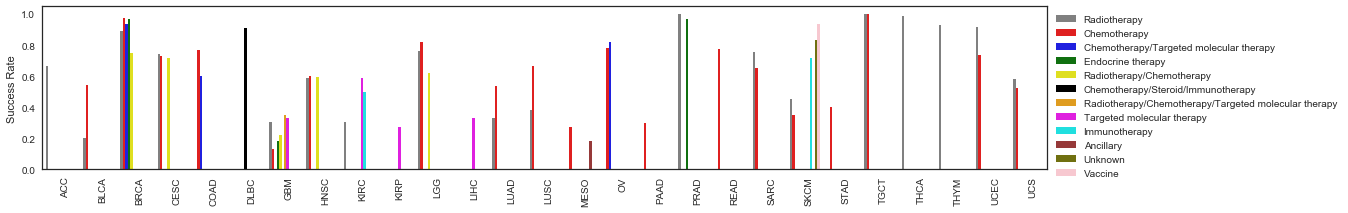

In [318]:
pallette = sns.color_palette(['gray','red','blue','green','yellow','black','orange','magenta','cyan','brown','olive','pink'])
# pallette = sns.color_palette("YlOrRd",12)
pl.figure(figsize=(18,3))
g = sns.barplot(x='tumor_type',y='successrate',hue='first therapy',data=successrate.reset_index(),palette=pallette)
g.legend(bbox_to_anchor=(1,1))
g.set_xticklabels(g.get_xticklabels(),rotation=90,ha="right",rotation_mode='anchor');
g.set_ylabel('Success Rate');
g.set_xlabel('');

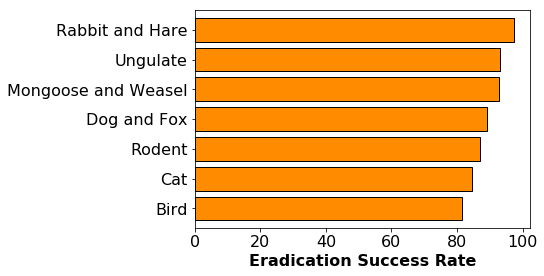

In [147]:
df = df.loc[AcceptableSpecies]
(df['Success Rate'].dropna()[::-1]*100).plot.barh(fontsize=16,color='darkorange',width=0.8,edgecolor='black')
pl.xlabel('Eradication Success Rate',fontsize=16,fontweight='bold')

In [150]:
import pandas as pd

df = pd.read_csv('diise_almost_all_islands.csv',na_values=['null','None'])
df = df[df['Data Quality'].isin(['Good','Satisfactory'])]
df = df[df['Country'] == 'New Zealand']

Groups = 'Type (Animal)' #'Scientific Name'
df = df.groupby(Groups)['Status (Eradication)'].apply(
    pd.value_counts).reset_index().pivot(index=Groups,columns='level_1',values='Status (Eradication)')
del df.index.name
del df.columns.name
# df = df[['Successful','Failed']]
df['Success Rate'] = df['Successful']/(df['Successful']+df['Failed'])#df.sum(axis=1,skipna=True)
df.sort_values('Success Rate',ascending=False,inplace=True)
df

,Failed,In Progress,Incomplete,Planned,Successful,Trial or Research only,Success Rate
Mongoose and Weasel,3.0,NaN,NaN,NaN,38.0,NaN,0.926829
Rodent,21.0,NaN,2.0,1.0,230.0,1.0,0.916335
Bird,1.0,NaN,NaN,NaN,8.0,NaN,0.888889
Cat,NaN,NaN,2.0,2.0,12.0,1.0,NaN
Mammal (Other),NaN,NaN,NaN,1.0,16.0,NaN,NaN
Rabbit and Hare,NaN,NaN,NaN,NaN,22.0,1.0,NaN
Ungulate,NaN,2.0,NaN,NaN,43.0,NaN,NaN


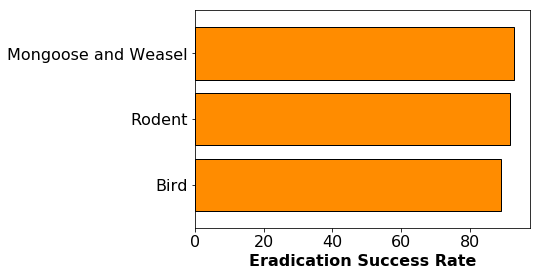

In [149]:
(df['Success Rate'].dropna()[::-1]*100).plot.barh(fontsize=16,color='darkorange',width=0.8,edgecolor='black')
pl.xlabel('Eradication Success Rate',fontsize=16,fontweight='bold')

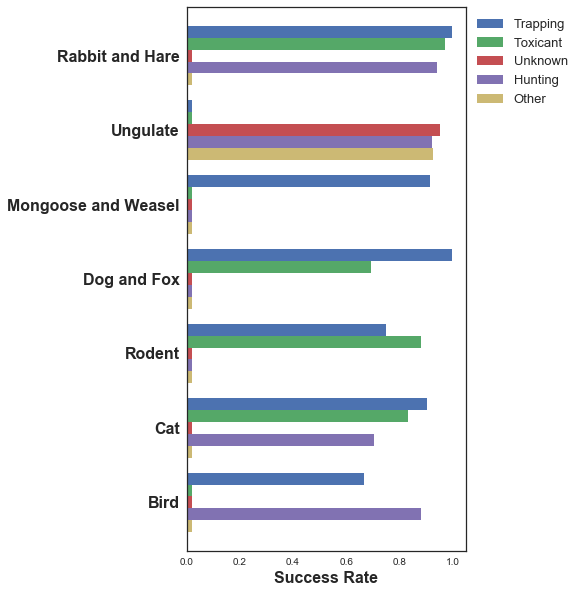

In [500]:
df = pd.read_csv('diise_almost_all_islands.csv',na_values=['null','None'])
df = df[df['Data Quality'].isin(['Good','Satisfactory'])]
AcceptableSpecies = df['Type (Animal)'].value_counts()>20
# df = df.groupby('Type (Animal)')['Primary Eradication Method'].value_counts().unstack()
# df = df.loc[AcceptableSpecies]
df = df.groupby(['Type (Animal)','Primary Eradication Method'])['Status (Eradication)'].apply(
    pd.value_counts).reset_index().pivot_table(
    index=['Type (Animal)','Primary Eradication Method'],
    columns='level_2',values='Status (Eradication)',fill_value=0)
df['SuccessPlusFailure'] = df['Successful']+df['Failed']
df['Success Rate'] = df['Successful']/df['SuccessPlusFailure']#df.sum(axis=1,skipna=True)
df = df[df['SuccessPlusFailure']>=10]
df.sort_values('Success Rate',ascending=False,inplace=True)
df = df.reset_index().pivot(index='Type (Animal)',columns = 'Primary Eradication Method', values = 'Success Rate')
df = df.loc[AcceptableSpecies].dropna(how='all',axis=0).dropna(how='all',axis=1)
del df.columns.name
del df.index.name
df = df.loc[df.mean(axis=1).sort_values(ascending=False).index]
col_sorted = df.max().sort_values(ascending=False).index
df = df[col_sorted]#.sort_values(list(col_sorted),ascending=True,na_position='first')
df.fillna(0.02).plot.barh(stacked=False,width=.8,figsize=(5,10)).legend(bbox_to_anchor=(1,1),fontsize=13)
pl.xlabel('Success Rate',fontsize=16,fontweight='bold');
g = pl.gca()
g.set_yticklabels(g.get_yticklabels(),fontsize=16,fontweight='bold');
g.invert_yaxis()

In [10]:
df = pd.read_csv('diise_almost_all_islands.csv',na_values=['null','None'])
df = df[df['Data Quality'].isin(['Good','Satisfactory'])]
AcceptableSpecies = df['Type (Animal)'].value_counts()>20
# df = df[df['Country'] == 'New Zealand']

Groups = 'Type (Animal)' #'Scientific Name'
df = df.groupby(Groups)['Status (Eradication)'].apply(
    pd.value_counts).reset_index().pivot(index=Groups,columns='level_1',values='Status (Eradication)')
del df.index.name
del df.columns.name
# df = df[['Successful','Failed']]
df['Success Rate'] = df['Successful']/(df['Successful']+df['Failed'])#df.sum(axis=1,skipna=True)
df.sort_values('Success Rate',ascending=False,inplace=True)
df

,Failed,In Progress,Incomplete,Planned,Successful,To Be Confirmed,Trial or Research only,Unknown,Unknown pre-status,Success Rate
Rabbit and Hare,2.0,2.0,4.0,1.0,72.0,1.0,1.0,NaN,NaN,0.972973
Ungulate,12.0,9.0,NaN,NaN,162.0,NaN,NaN,NaN,NaN,0.931034
Mongoose and Weasel,4.0,2.0,NaN,NaN,51.0,NaN,NaN,NaN,NaN,0.927273
Dog and Fox,4.0,NaN,NaN,NaN,33.0,NaN,NaN,NaN,NaN,0.891892
Rodent,98.0,18.0,3.0,5.0,651.0,35.0,9.0,3.0,17.0,0.869159
Cat,14.0,3.0,4.0,3.0,77.0,1.0,5.0,NaN,NaN,0.846154
Bird,7.0,5.0,1.0,NaN,31.0,NaN,NaN,NaN,NaN,0.815789
Amphibian,NaN,1.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
Bird (Raptor),NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN
Mammal (Other),NaN,1.0,NaN,1.0,23.0,3.0,NaN,NaN,NaN,NaN
